In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import os
import sys
sys.path.append('..')

from utilities import configuration
from utilities import logger
from utilities import health_data

from sklearn.linear_model import LogisticRegression

In [2]:
config = configuration.get_config()

# Retrieving model and experiment configurations 
model_configurations = json.load(open(config['models_config'], encoding='utf-8'))
experiment_configurations = json.load(open(config['experiments_config'], encoding='utf-8'))


params = experiment_configurations['configuration_0']

# Computing training and testing matrices.
X_train, y_train, X_test, y_test, feature_names = health_data.Admission.get_train_test_matrices(
    fix_missing_in_testing=params['fix_missing_in_testing'],
    normalize=params['normalize'],
    fix_skew=params['fix_skew'],
    numerical_features=params['numerical_features'],
    categorical_features=params['categorical_features'],
    diagnosis_features=params['diagnosis_features'],
    intervention_features=params['intervention_features'],
    use_idf=params['use_idf'],
    remove_outliers=params['remove_outliers'],
    )


# Creating classification model and training ...
model = LogisticRegression(max_iter=1000, class_weight='balanced')

model.fit(X_train, y_train)

# Evaluating metrics on TRAINING
y_true = y_train
y_pred = model.predict(X_train)
y_score= model.predict_proba(X_train)

model_name = str(model)
columns = ['Model',
        'split',
        'TN',
        'FP',
        'FN',
        'TP',
        'Precision',
        'Recall',
        'F1-Score',
        'AUC', 
        ]

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
vec1 = [model_name,
        'TRAIN',
        tn,
        fp,
        fn,
        tp,
        precision_score(y_true, y_pred,),
        recall_score(y_true, y_pred,),
        f1_score(y_true, y_pred,),
        roc_auc_score(y_true=y_true, y_score=y_pred)
        ]

# Evaluating metrics on TESTING
y_true = y_test
y_pred = model.predict(X_test)
y_score= model.predict_proba(X_test)

tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()    
vec2 = [model_name,
        'TEST',
        tn,
        fp,
        fn,
        tp,
        precision_score(y_true, y_pred,),
        recall_score(y_true, y_pred,),
        f1_score(y_true, y_pred,),
        roc_auc_score(y_true=y_true, y_score=y_pred)
        ]

m = np.vstack([vec1, vec2])
new_df = pd.DataFrame(m, columns=columns)
new_df

/Users/marianomaisonnave/Environments/alc/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Model,split,TN,FP,FN,TP,Precision,Recall,F1-Score,AUC
0,"LogisticRegression(class_weight='balanced', ma...",TRAIN,243297,156210,5110,12260,0.07277260046299044,0.7058146229130685,0.13194145501506674,0.6574038534445346
1,"LogisticRegression(class_weight='balanced', ma...",TEST,61357,38994,1371,3162,0.07500711642470823,0.6975512905360688,0.13544946347105313,0.6544875963198424


In [3]:
diagnosis_mapping = health_data.Admission.get_diagnoses_mapping()
intervention_mapping = health_data.Admission.get_intervention_mapping()

In [5]:
features = [(name,importance) for importance,name in zip(model.coef_[0,:], feature_names)]
features = sorted(features, key=lambda x: (x[1]))
for word, score in features[-20:][::-1]:
    if word.upper() in diagnosis_mapping:
        print(f'{word:10} - {score:+4.3f} - {diagnosis_mapping[word.upper()]}')
    if word.upper() in intervention_mapping:
        print(f'{word:10} - {score:+4.3f} - {intervention_mapping[word.upper()]}')


j9501      - +1.075 - {'Infection of tracheostomy stoma'}
i672       - +0.869 - {'Cerebral atherosclerosis'}
z049       - +0.858 - {'Examination and observation for unspecified reason'}
a310       - +0.853 - {'Pulmonary mycobacterial infection'}
2bb71la    - +0.774 - {'Biopsy, nerves of head and neck using open approach'}
d059       - +0.761 - {'Carcinoma in situ of breast, unspecified'}
z608       - +0.672 - {'Other problems related to social environment'}
c915       - +0.657 - {'Adult T-cell lymphoma/leukaemia [HTLV-1 associated]'}
a179       - +0.644 - {'Tuberculosis of nervous system, unspecified'}
1pb89qf    - +0.640 - {'Excision total, adrenal gland using open thoracoabdominal approach'}
z080       - +0.605 - {'Follow-up examination after surgery for malignant neoplasm'}
z082       - +0.601 - {'Follow-up examination after chemotherapy for malignant neoplasm'}
c923       - +0.585 - {'Myeloid sarcoma'}
a1690      - +0.578 - {'Respiratory tuberculosis unspecified, without mention of

In [6]:
features = [(name,importance) for importance,name in zip(model.coef_[0,:], feature_names)]
features = sorted(features, key=lambda x: (x[1]))
for word, score in features[:20]:
    if word.upper() in diagnosis_mapping:
        print(f'{word:10} - {score:+4.3f} - {diagnosis_mapping[word.upper()]}')
    if word.upper() in intervention_mapping:
        print(f'{word:10} - {score:+4.3f} - {intervention_mapping[word.upper()]}')


a158       - -1.010 - {'Other respiratory tuberculosis, confirmed bacteriologically and histologically'}
z614       - -0.982 - {'Problems related to alleged sexual abuse of child by person within primary support group'}
a1500      - -0.764 - {'Tuberculosis of lung, confirmed by sputum microscopy with or without culture, with cavitation'}
a182       - -0.727 - {'Tuberculous peripheral lymphadenopathy'}
5pc80jp    - -0.688 - {'Surgical repair, postpartum, of current obstetric laceration of pelvic floor, perineum, lower vagina'}
2aj71sz    - -0.684 - {'Biopsy, cerebellum using open craniotomy or craniectomy [flap] approach'}
z467       - -0.683 - {'Fitting and adjustment of orthopaedic device'}
1hn71la    - -0.666 - {'Division, interatrial septum open septectomy [Blalock Hanlon technique]'}
u993       - -0.633 - {'While engaged in other types of work'}
a1501      - -0.627 - {'Tuberculosis of lung, confirmed by sputum microscopy with or without culture, without cavitation or '}
z859       

In [5]:
len(feature_names)

17136

In [11]:
pd.DataFrame(np.random.rand(100,5), columns=['a', 'b', 'c', 'd', 'e'])

,a,b,c,d,e
0,0.798324,0.203221,0.749533,0.541501,0.024743
1,0.862883,0.834529,0.055534,0.176318,0.132039
2,0.973334,0.660282,0.242053,0.175789,0.957876
3,0.418507,0.114926,0.811999,0.965329,0.122220
4,0.233054,0.998555,0.928478,0.665971,0.513512
...,...,...,...,...,...
95,0.122393,0.243645,0.471516,0.338490,0.541373
96,0.588154,0.712909,0.030581,0.287967,0.477247
97,0.188171,0.935682,0.846234,0.923482,0.211693
98,0.371111,0.791648,0.726759,0.818274,0.742435


In [12]:
X_train

<416877x17136 sparse matrix of type '<class 'numpy.float64'>'
	with 6686332 stored elements in Compressed Sparse Row format>

In [13]:
X_df = pd.DataFrame(X_train.toarray(), columns=feature_names)
print(X_df.shape)


(416877, 17136)


In [14]:
# Linear Regression SHAP
import sklearn

import shap

# a classic housing price dataset
# X, y = shap.datasets.california(n_points=1000)

X = X_df
y = y_train
X100 = shap.utils.sample(X, 100)  # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

explainer = shap.Explainer(model.predict, X100)
shap_values = explainer(X)

# make a standard partial dependence plot
sample_ind = 20

# the waterfall_plot shows how we get from shap_values.base_values to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values[sample_ind], max_display=14)

: 

In [50]:
# a classic adult census dataset price dataset
X_adult, y_adult = shap.datasets.adult()

# a simple linear logistic model
model_adult = sklearn.linear_model.LogisticRegression(max_iter=10000)
model_adult.fit(X_adult, y_adult)


def model_adult_proba(x):
    return model_adult.predict_proba(x)[:, 1]


def model_adult_log_odds(x):
    p = model_adult.predict_log_proba(x)
    return p[:, 1] - p[:, 0]

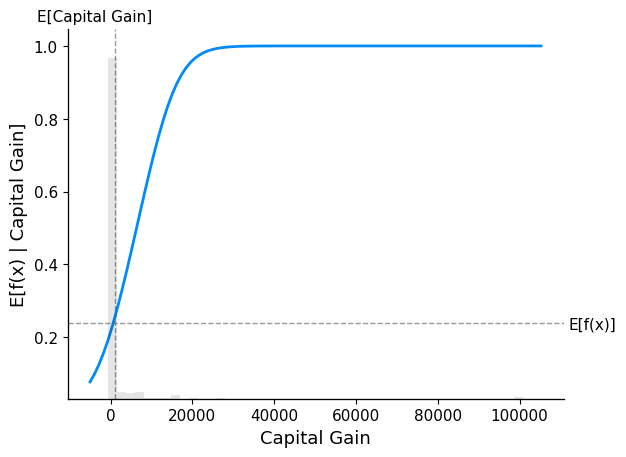

In [51]:
# make a standard partial dependence plot
sample_ind = 18
fig, ax = shap.partial_dependence_plot(
    "Capital Gain",
    model_adult_proba,
    X_adult,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
)

PermutationExplainer explainer: 1001it [00:55, 13.67it/s]                         


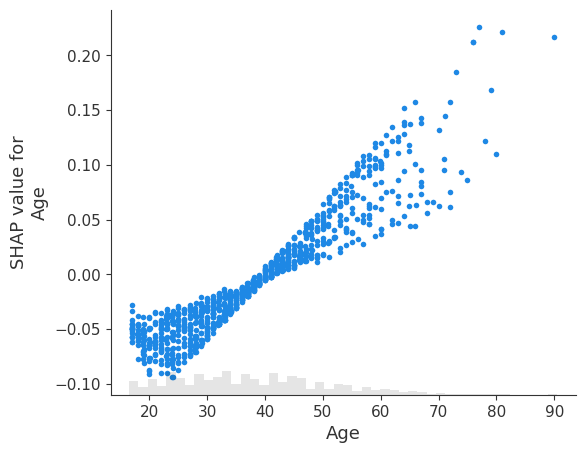

In [52]:
# compute the SHAP values for the linear model
background_adult = shap.maskers.Independent(X_adult, max_samples=100)
explainer = shap.Explainer(model_adult_proba, background_adult)
shap_values_adult = explainer(X_adult[:1000])
shap.plots.scatter(shap_values_adult[:, "Age"])


In [ ]:
#  train XGBoost model
model = xgboost.XGBClassifier(n_estimators=100, max_depth=2).fit(
    X_adult, y_adult * 1, eval_metric="logloss"
)

# compute SHAP values
explainer = shap.Explainer(model, background_adult)
shap_values = explainer(X_adult)

# set a display version of the data to use for plotting (has string values)
shap_values.display_data = shap.datasets.adult(display=True)[0].values

shap.plots.bar(shap_values)


In [43]:
new_predict_proba = explainer = lambda x: model.predict_proba(x)[:,1]
new_predict_proba(X100).shape

(100,)

In [39]:
explainer = shap.Explainer(lambda x: model.predict_proba(x)[:,1], X100)
print()
shap_values = explainer(X)

sample_ind=1
shap.plots.waterfall(shap_values[sample_ind], max_display=14)



DimensionError: The passed data does not match the background shape expected by the masker! The data of shape (1, 17136) was passed while the masker expected data of shape (17136,).

In [31]:
X.iloc[0,:]

MedInc           4.151800
HouseAge        22.000000
AveRooms         5.663073
AveBedrms        1.075472
Population    1551.000000
AveOccup         4.180593
Latitude        32.580000
Longitude     -117.050000
Name: 14740, dtype: float64

### Feature Selection (recursive feature elimination)

In [2]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import os
import sys
sys.path.append('..')

from utilities import configuration
from utilities import logger
from utilities import health_data

from sklearn.linear_model import LogisticRegression

In [4]:
config = configuration.get_config()

experiment_configurations = json.load(open(config['experiments_config'], encoding='utf-8'))


params = experiment_configurations['configuration_0']


X_train, y_train, X_test, y_test, feature_names = health_data.Admission.get_train_test_matrices(
    fix_missing_in_testing=params['fix_missing_in_testing'],
    normalize=params['normalize'],
    fix_skew=params['fix_skew'],
    numerical_features=params['numerical_features'],
    categorical_features=params['categorical_features'],
    diagnosis_features=params['diagnosis_features'],
    intervention_features=params['intervention_features'],
    use_idf=params['use_idf'],
    remove_outliers=params['remove_outliers'],
    )

In [5]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.datasets import make_friedman1
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

under = RandomUnderSampler(sampling_strategy=1)

X, y = under.fit_resample(X_train, y_train)


print('Creating model ...')
estimator = LogisticRegression(max_iter=5000, )

print('Creating RFE')
selector = RFE(estimator, n_features_to_select=20, step=1)

print('RFE fitting')
selector = selector.fit(X, y)


Creating model ...
Creating RFE
RFE fitting


/Users/marianomaisonnave/Environments/alc/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/marianomaisonnave/Environments/alc/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

KeyboardInterrupt: 

### SelectKBest

In [1]:
import pandas as pd
import numpy as np
import json
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import os
import sys
sys.path.append('..')

from utilities import configuration
from utilities import logger
from utilities import health_data

from sklearn.linear_model import LogisticRegression

In [2]:
config = configuration.get_config()

experiment_configurations = json.load(open(config['experiments_config'], encoding='utf-8'))


params = experiment_configurations['configuration_5']


X_train, y_train, X_test, y_test, feature_names = health_data.Admission.get_train_test_matrices(params)

In [4]:
print(X_train.shape)
print(X_test.shape)
print(feature_names.shape)

(416877, 50)
(104884, 50)
(50,)


In [5]:
for ix in range(X_train.shape[1]):
    if np.var(X_train[:,ix].toarray())==0:
        print(f'{ix:10} - {feature_names[ix]}')

In [6]:
X_train.shape

(416877, 17136)

In [7]:
X_train[:,~constant_variables].shape

(416877, 17036)

In [8]:
X_test[:,~constant_variables].shape

(104884, 17036)

In [15]:
'1kt55lanr' in (np.array(feature_names)[~constant_variables])

False

In [13]:
(np.array(feature_names)[~constant_variables])

array(['age', 'cmg', 'case_weight', ..., '8ta70habw', '8zz70grbw',
       '8zz70habw'], dtype='<U30')

In [3]:

np.sum(constant_variables)


100

array(['age', 'cmg', 'case_weight', ..., '8ta70habw', '8zz70grbw',
       '8zz70habw'], dtype='<U30')

In [10]:
diagnosis_mapping = health_data.Admission.get_diagnoses_mapping()
intervention_mapping = health_data.Admission.get_intervention_mapping()

In [14]:
list(diagnosis_mapping)[:10]

['K746', 'K431', 'R18', 'K760', 'K650', 'I518', 'L988', 'L984', 'K439', 'J90']

In [7]:
from sklearn.datasets import load_digits
from sklearn.feature_selection import SelectKBest, f_classif
# X, y = load_digits(return_X_y=True)

clf = SelectKBest(f_classif, k=50, ).fit(X_train, y_train)
X_new = clf.transform(X_train)
X_new

<416877x50 sparse matrix of type '<class 'numpy.float64'>'
	with 2515446 stored elements in Compressed Sparse Row format>

In [12]:
len((clf.transform(feature_names.reshape(1,-1))[0,:]))

50

In [15]:
for ix,variable_name in enumerate(clf.transform(feature_names.reshape(1,-1))[0,:]):
    if variable_name.upper() in diagnosis_mapping:
        print(f'{ix};{variable_name.upper()};{str(diagnosis_mapping[variable_name.upper()]):20}')
    elif variable_name.upper() in intervention_mapping:
        print(f'{ix};{variable_name.upper()};{str(intervention_mapping[variable_name.upper()]):20}')
    else:
        print(f'{ix};'+variable_name+';')

0;age;
1;cmg;
2;alc_days;
3;transfusion given;
4;is alc;
5;elective admission;
6;urgent admission;
7;level 1 comorbidity;
8;level 2 comorbidity;
9;Direct Entry;
10;Emergency Entry;
11;New Acute Patient;
12;Panned Readmit;
13;Unplanned Readmit;
14;Haematology;
15;OBS Delivered;
16;Orthopaedic Surgery;
17;Family Practice;
18;Psychiatry;
19;General Medicine;
20;Newborn;
21;C920;{'Acute myeloblastic leukaemia [AML]'}
22;D630;{'Anaemia in neoplastic disease'}
23;D700;{'Neutropenia'}     
24;D806;{'Antibody deficiency with near-normal immunoglobulins or with hyperimmunoglobulinaemia'}
25;D828;{'Immunodeficiency associated with other specified major defects'}
26;E1123;{'Unspecified glomerular disorders in diabetes mellitus', 'Type 2 diabetes mellitus with other specified kidney complication not elsewhere classified', 'Unspecified diabetes mellitus with established or advanced kidney disease', 'Type 2 diabetes mellitus with established or advanced kidney disease'}
27;F603;{'Emotionally unstabl

NameError: name 'X_new' is not defined

In [19]:
clf.get_feature_names_out()

array(['age', 'cmg', 'acute_days', 'alc_days', 'transfusion given',
       'elective admission', 'urgent admission', 'level 1 comorbidity',
       'level 2 comorbidity', 'Direct Entry', 'Emergency Entry',
       'New Acute Patient', 'Panned Readmit', 'Newborn',
       'Orthopaedic Surgery', 'OBS Delivered', 'c920', 'j441', 'z37000',
       '1zz35ham2'], dtype=object)

In [12]:
training,testing = health_data.Admission.get_training_testing_data(filtering=True)

In [14]:
set([admission.readmission_code.is_unplanned_readmit for admission in training])

{<function utilities.health_data.ReadmissionCode.is_unplanned_readmit(admission_code: typing_extensions.Self)>}

In [33]:
experiment_configurations = json.load(open(config['experiments_config'], encoding='utf-8'))
experiment_configurations['configuration_5']

{'fix_skew': False,
 'normalize': False,
 'fix_missing_in_testing': True,
 'numerical_features': True,
 'categorical_features': True,
 'diagnosis_features': True,
 'intervention_features': True,
 'use_idf': False,
 'class_balanced': False,
 'remove_outliers': True,
 'under_sample_majority_class': False,
 'over_sample_minority_class': False,
 'smote_and_undersampling': False,
 'feature_selection': True,
 'k_best_features': 50}

In [35]:
X_train, y_train, X_test, y_test, columns = health_data.Admission.get_train_test_matrices(experiment_configurations['configuration_0'])

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/marianomaisonnave/Environments/alc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/d0/9279s72s163gx0_12qbmr9440000gn/T/ipykernel_23142/586933612.py", line 1, in <module>
    X_train, y_train, X_test, y_test, columns = health_data.Admission.get_train_test_matrices(experiment_configurations['configuration_0'])
  File "/Users/marianomaisonnave/Repositories/alternate-level-of-care-project/notebooks/../utilities/health_data.py", line 757, in get_train_test_matrices
UnboundLocalError: local variable 'is_outlier' referenced before assignment

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/marianomaisonnave/Environments/alc/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2105, in showtraceback
    stb = self.InteractiveTB.structured_traceback(

In [31]:
# Retrieving configuration (paths) and initializing logger
config = configuration.get_config()

# Retrieving model and experiment configurations 
model_configurations = json.load(open(config['models_config'], encoding='utf-8'))
experiment_configurations = json.load(open(config['experiments_config'], encoding='utf-8'))

# CHECKING PENDINGS:
to_do = []
for model_id,model_config in model_configurations.items():
    if not ('skipping' in model_config and model_config['skipping']):
        configurations_to_run = [config_id for config_id in model_config['configuration_ids']]
        to_do += [(config_id, model_id) for config_id in configurations_to_run]

to_do = set(to_do)

already_run_df = pd.read_csv(config['experiment_results'], sep=';')

already_ran = [(config_id, model_id) for config_id, model_id in zip(already_run_df['config_id'], already_run_df['model_id'])]
already_ran = set(already_ran)

pending = to_do.difference(already_ran)
pending_conf = set([config_id for config_id, model_id in pending])

print(len(experiment_configurations))
experiment_configurations = {configuration_id:configuration_dict 
                                for configuration_id, configuration_dict in experiment_configurations.items()
                                if configuration_id in pending_conf
                                }
print(len(experiment_configurations))

pending

7
1


{('configuration_6', 'model_54')}

[('configuration_0', 'model_8'),
 ('configuration_0', 'model_8'),
 ('configuration_0', 'model_2'),
 ('configuration_0', 'model_2'),
 ('configuration_0', 'model_6'),
 ('configuration_0', 'model_6'),
 ('configuration_0', 'model_7'),
 ('configuration_0', 'model_7'),
 ('configuration_0', 'model_12'),
 ('configuration_0', 'model_12'),
 ('configuration_0', 'model_13'),
 ('configuration_0', 'model_13'),
 ('configuration_0', 'model_15'),
 ('configuration_0', 'model_15'),
 ('configuration_0', 'model_16'),
 ('configuration_0', 'model_16'),
 ('configuration_0', 'model_20'),
 ('configuration_0', 'model_20'),
 ('configuration_0', 'model_23'),
 ('configuration_0', 'model_23'),
 ('configuration_0', 'model_0'),
 ('configuration_0', 'model_0'),
 ('configuration_0', 'model_1'),
 ('configuration_0', 'model_1'),
 ('configuration_0', 'model_3'),
 ('configuration_0', 'model_3'),
 ('configuration_0', 'model_4'),
 ('configuration_0', 'model_4'),
 ('configuration_0', 'model_9'),
 ('configuration_0', 'model_9')